In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFilter
import os
import cv2
import random
import tensorflow as tf

from tensorflow import keras

In [2]:
from imutils import paths
import face_recognition
import pickle
import cv2
import os

In [3]:
# Загружаем файл каскада Хаарта
faceCascade = cv2.CascadeClassifier(r"D:\TeachMeSkills\DZ\dz22\haarcascade_frontalface_alt2.xml")

In [4]:
imagePaths =r'./wiki_crop/new'

In [6]:
from tqdm import tqdm

In [7]:
df = pd.DataFrame(columns=['link', 'age']) ### Создаем пустой Dataframe с колонками Link - ссылка на файл, Age - Возраст

for dirname, _,filenames in tqdm(os.walk(r'./wiki_crop')):
    for filename in filenames:
        #формируем ссылку на изображение
        link = os.path.join(dirname, filename)
        
         #### Распознавание лица с помощью каскадов Хаара
        img = cv2.imread(link)
####        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if img.shape[-1]==3:
            img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_new = img
        
        faces = faceCascade.detectMultiScale(img_new,
                                     scaleFactor=1.1,
                                     minNeighbors=5,
                                     minSize=(60, 60),
                                     flags=cv2.CASCADE_SCALE_IMAGE)
        if len(faces)==1:
            end = filename[-8:-4]
            start = filename.split('_')[1].split('-')[0]
            age = int(end)-int(start)
            x, y, w, h = faces[0]
            face_selected = img[y:y+h, x:x+h]
            link2 = os.path.join(r'./wiki_crop/new', filename)
            cv2.imwrite(link2,face_selected)             ### Сохраним в файл с таким же именем, но в новую папку.\n",
            df.loc[len(df.index )] = [link2,age]
df.drop_duplicates (subset=['link'])            

102it [18:40, 10.99s/it] 


,link,age
0,./wiki_crop/new\10049200_1891-09-16_1958.jpg,67
1,./wiki_crop/new\10110600_1985-09-17_2012.jpg,27
2,./wiki_crop/new\10126400_1964-07-07_2010.jpg,46
3,./wiki_crop/new\1013900_1917-10-15_1960.jpg,43
4,./wiki_crop/new\10166400_1960-03-12_2008.jpg,48
...,...,...
30611,./wiki_crop/new\9598699_1901-05-21_1980.jpg,79
30612,./wiki_crop/new\961599_1950-01-12_2009.jpg,59
30613,./wiki_crop/new\9799_1960-06-22_2012.jpg,52
30614,./wiki_crop/new\981199_1954-12-30_2006.jpg,52


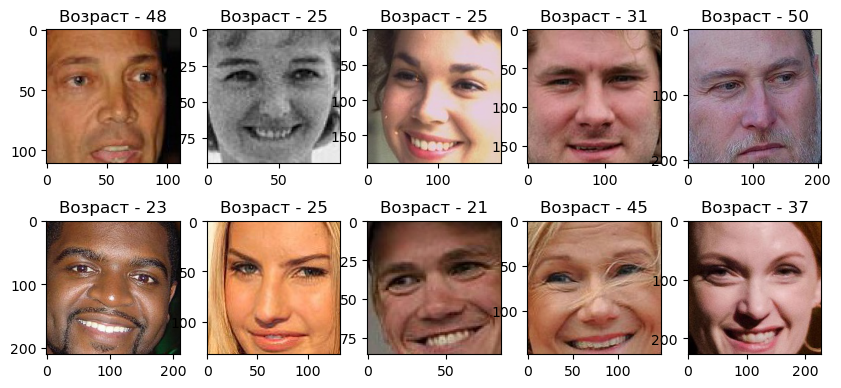

In [8]:
idx = np.random.randint (0,len(df),10)
plt.figure(figsize=(10,12))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = df.iloc[idx[1]]
        image = plt.imread(link[0])
        title = 'Возраст - ' + str(link[1])
        plt.title (title)
        plt.imshow(image, cmap='gray')

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,GlobalMaxPool2D, Conv2D, MaxPooling2D,Activation, Flatten, CategoryEncoding,Dropout, BatchNormalization, AveragePooling2D
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import RootMeanSquaredError

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=34)

In [11]:
train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.3)
test_datagen=ImageDataGenerator(rescale=1./255.)

In [25]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="training",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train,
directory="./",
x_col="link",
y_col="age",
subset="validation",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory="./",
x_col="link",
y_col="age",
class_mode="raw",
target_size=(64,64),
batch_size=32,
seed=42,
shuffle=True,
color_mode='rgb')

Found 30967 validated image filenames.
Found 13271 validated image filenames.
Found 11060 validated image filenames.


In [28]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(64,64,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
#model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model.add(GlobalMaxPool2D())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer = Adam(),loss="mse", metrics=["mae"])


In [30]:
checkpoint_cb_conv = ModelCheckpoint("Model.h5",
                                         monitor = 'val_mae',
                                         save_best_only=True)
    
lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=2)

In [31]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=20)

Epoch 1/20
968/968 [==============================] - 121s 124ms/step - loss: 438.5058 - mae: 13.6524 - val_loss: 309.8867 - val_mae: 12.4032
Epoch 2/20
968/968 [==============================] - 111s 115ms/step - loss: 348.3882 - mae: 11.2278 - val_loss: 202.6276 - val_mae: 10.4683
Epoch 3/20
968/968 [==============================] - 111s 115ms/step - loss: 315.6308 - mae: 10.1881 - val_loss: 191.0958 - val_mae: 10.7013
Epoch 4/20
968/968 [==============================] - 136s 140ms/step - loss: 308.6645 - mae: 10.1093 - val_loss: 148.9909 - val_mae: 8.8658
Epoch 5/20
968/968 [==============================] - 140s 144ms/step - loss: 294.9616 - mae: 9.7481 - val_loss: 151.4750 - val_mae: 8.9517
Epoch 6/20
968/968 [==============================] - 128s 132ms/step - loss: 289.5792 - mae: 9.5197 - val_loss: 184.3587 - val_mae: 10.1092
Epoch 7/20
968/968 [==============================] - 129s 133ms/step - loss: 309.0685 - mae: 10.2333 - val_loss: 162.9599 - val_mae: 9.1828
Epoch 8/20


In [32]:
model.evaluate (test_generator)

346/346 [==============================] - 17s 49ms/step - loss: 217.3834 - mae: 10.6412


[217.38343811035156, 10.641182899475098]

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 activation_30 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 32)        18464     
                                                                 
 activation_31 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                 

In [34]:
len(test)

11060

1/1 [==============================] - 0s 36ms/step


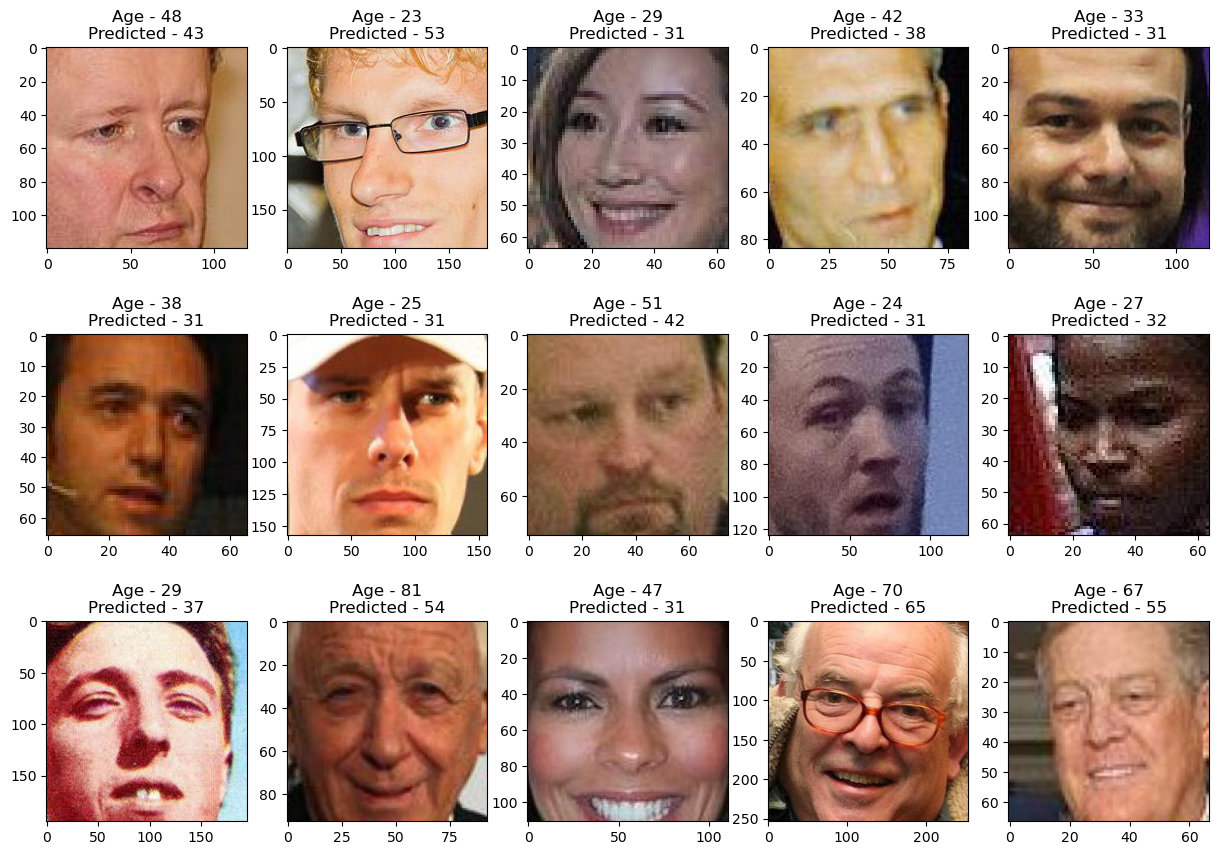

In [35]:
idx = np.random.randint (0,len(test),15)
plt.figure(figsize=(15,18))
for idx in enumerate(idx):
        plt.subplot (5,5,idx[0]+1)
        link = test.iloc[idx[1]]
        image = plt.imread(link[0])
      
        img_resized = cv2.resize (image, (64,64))/255
        img_reshaped  = img_resized.reshape (1,64,64,3)
        predict = model.predict(img_reshaped)[0][0]
    
        title = 'Age - ' + str(link[1]) + '\nPredicted - ' + str(int(predict))
        plt.title (title)
        plt.imshow(image, cmap='gray')

-------------------------------------------------------------------------

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

In [ ]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer = Adam(),loss="mse", metrics=["mae"])

history = model.fit(train_generator, validation_data=valid_generator, epochs=10)

